## DeepSat (SAT-6) Airborne Dataset Analysis 
+ Purpose is to characterize the DeepSat Data/images into categories accurately
+ First step will be to be able to feed the data into a simple CNN using Batch Normalization and check the performance

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
path_a = os.getcwd()+"\datasets\crawford\deepsat-sat6"
print(f"path of the project : {path_a}")

# Print the contents of the path
from glob import glob
trainfiles, testfiles = [],[]
to_scan = path_a+"\*.csv"

for f in glob(to_scan):
    if "train" in f: 
        trainfiles.append(f)
    elif "test" in f: 
        testfiles.append(f)

# xtrain.iloc[0:0]
# ytrain.iloc[0:0]
# x_train.iloc[0:0]
# y_train.iloc[0:0]
xtrain = pd.read_csv(tf.gfile.Open(trainfiles[0]), nrows=50000, header=None) 
ytrain = pd.read_csv(tf.gfile.Open(trainfiles[1]), nrows=50000, header=None)
x_train = xtrain.values.reshape((xtrain.shape[0],28,28,4)).clip(0,255).astype(np.float32)
y_train = ytrain.values.astype(np.float32)

path of the project : C:\Public\xrelab\Xrelab\final-project\datasets\crawford\deepsat-sat6


In [3]:
print(trainfiles, testfiles)

['C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\X_train_sat6.csv', 'C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\y_train_sat6.csv'] ['C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\X_test_sat6.csv', 'C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\y_test_sat6.csv']


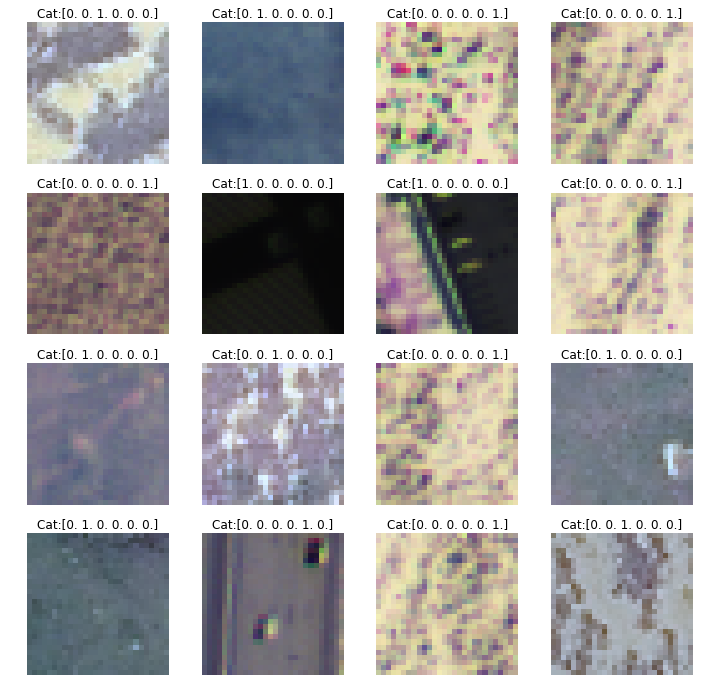

In [4]:
import matplotlib.pyplot as plt
c_train_x, c_train_y = x_train[0:16],y_train[0:16] 
fig, m_axs = plt.subplots(4, c_train_x.shape[0]//4, figsize = (12, 12))
for (x, y, c_ax) in zip(c_train_x, c_train_y, m_axs.flatten()):
    c_ax.imshow(x[:,:,:3],interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title('Cat:{}'.format(y))

In [5]:
xtest = pd.read_csv(tf.gfile.Open(testfiles[0]), nrows=4000, header=None) 
ytest = pd.read_csv(tf.gfile.Open(testfiles[1]), nrows=4000, header=None)
x_test = xtest.values.reshape((xtest.shape[0],28,28,4)).clip(0,255).astype(np.float32)
y_test = ytest.values.astype(np.float32)

## Put the Tensorflow model in Place 
+ Simple CNN with no Batch Normalization
+ Simple CNN with Batch Normalization
+ Simple CNN with Group Normalization

In [6]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 28, 28, 4) (50000, 6) (4000, 28, 28, 4) (4000, 6)


In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import argparse
import os
import sys

FLAGS=None

tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
def cnn_model_fn(features, labels, mode, params, config):
    #Input layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 4])
    
    # Convolutional Layer #1
    conv1=tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[5,5],
            padding="same",
            activation=tf.nn.relu6)
    
    print("Shape Conv1:" + str(conv1.shape))
    
    # First Max Pooling layer
    pool1=tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2) #strides=2 . Divide size by 2
    
    print("Shape Pool1:" + str(pool1.shape))
    
    # Convolutional Layer #2
    conv2=tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5,5],
            padding="same",
            activation=tf.nn.relu6)
    
    print("Shape Conv2:" + str(conv2.shape))
    
    # Second Max Pooling layer
    pool2=tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2) #strides=2 . Divide size by 2
    
    print("Shape Pool2:" + str(pool2.shape))
    
    #Flatten Pool 2
    pool2_flat = tf.reshape(pool2, [-1, int(pool2.shape[1]) * int(pool2.shape[2]) * int(pool2.shape[3])])
    
    #Dense Layer
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu6)
    
    #Dropout
    dropout = tf.layers.dropout(inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Second Dense Layer
    dense2 = tf.layers.dense(inputs=dropout, units=256, activation=tf.nn.relu6)
    
    #Output layer final
    logits = tf.layers.dense(inputs=dense2, units=labels.shape[1])
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # Predict Mode
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Loss Function
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
    
    
    # Classification Metrics
    # accuracy
    acc  = tf.metrics.accuracy(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # Precision
    prec = tf.metrics.precision(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # Recall
    rec = tf.metrics.recall(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # F1 Score
    f1 = 2 * acc[1] * rec[1] /(prec[1] + rec[1]) 
    
    
    #TensorBoard Summary
    with tf.name_scope('summaries'):
        tf.summary.scalar('Accuracy', acc[1])
        tf.summary.scalar('Precision', prec[1])
        tf.summary.scalar('Recall', rec[1])
        tf.summary.scalar('F1Score', f1)
        tf.summary.histogram('Probabilities', predictions['probabilities'])
        tf.summary.histogram('Classes', predictions['classes'])
    
    summary_hook = tf.train.SummarySaverHook(summary_op=tf.summary.merge_all(),save_steps=1)
    
    # Learning Rate Decay (Exponential)
    learning_rate = tf.train.exponential_decay(learning_rate=1e-04,
                                               global_step=tf.train.get_global_step(),
                                               decay_steps=10000, 
                                               decay_rate=0.96, 
                                               staircase=True,
                                               name='lr_exp_decay')
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    
    # Evaluation Metrics
    eval_metric_ops = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
    }
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [18]:
sat6_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="C:/Public/xrelab/Xrelab/final-project/cnn_model",
                                         config=tf.estimator.RunConfig())
tensors_to_log={"probabilities":"softmax_tensor"}
logging_hook=tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=20)
# Training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x_train},
                                                    y=y_train,
                                                    batch_size=512,
                                                    num_epochs=1,
                                                    shuffle=True)
# Evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x_test},
                                                   y=y_test,
                                                   num_epochs=1,
                                                   shuffle=False)

#
sat6_classifier.train(input_fn=train_input_fn, steps=100, hooks=[logging_hook])
# for i in range(10):
#     sat6_classifier.train(input_fn=train_input_fn, hooks=[logging_hook])
#     eval_results=sat6_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Using config: {}
Shape Conv1:(?, 28, 28, 32)
Shape Pool1:(?, 14, 14, 32)
Shape Conv2:(?, 14, 14, 64)
Shape Pool2:(?, 7, 7, 64)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:/Public/xrelab/Xrelab/final-project/cnn_model\model.ckpt.
INFO:tensorflow:loss = 3.0258882, step = 1
INFO:tensorflow:probabilities = [[0.16260342 0.72241235 0.02023628 0.02961172 0.00190236 0.06323395]
 [0.23766817 0.5790992  0.02582485 0.14657527 0.00019376 0.0106387 ]
 [0.00396645 0.03538607 0.841623   0.00325033 0.0039998  0.11177427]
 ...
 [0.02168995 0.3080631  0.60810053 0.04130125 0.00369242 0.0171528 ]
 [0.04050127 0.24416092 0.41055793 0.00628534 0.0066472  0.2918474 ]
 [0.0029951  0.9907679  0.00125587 0.00178563 0.0014484  0.0017472 ]]
INFO:tensorflow:probabilities = [[0.00525542 0.00817261 0.07633617 0.90873575 0.00065289 0.00084715]
 [0.01909086 0.00351283 0.00236225 0.03708324 0.00193844 0.93601245]
 [0.0809524  0.01156597 0.04869136 0.28688

In [19]:
eval_results=sat6_classifier.evaluate(input_fn=eval_input_fn)

Shape Conv1:(?, 28, 28, 32)
Shape Pool1:(?, 14, 14, 32)
Shape Conv2:(?, 14, 14, 64)
Shape Pool2:(?, 7, 7, 64)
INFO:tensorflow:Starting evaluation at 2018-10-01-14:19:08
INFO:tensorflow:Restoring parameters from C:/Public/xrelab/Xrelab/final-project/cnn_model\model.ckpt-98
INFO:tensorflow:Finished evaluation at 2018-10-01-14:19:15
INFO:tensorflow:Saving dict for global step 98: Accuracy = 0.877, Precision = 0.9708216, Recall = 0.9918933, global_step = 98, loss = 0.3487776


In [20]:
print(eval_results)

{'Accuracy': 0.877, 'Precision': 0.9708216, 'Recall': 0.9918933, 'loss': 0.3487776, 'global_step': 98}
